# Analysis of extractive structures results

### Imports

In [40]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from oocr_influence.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from oocr_influence.utils import cache_function_outputs

repo_root = get_root_of_git_repo()
if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from oocr_influence.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from oocr_influence.datasets.utils import get_data_collator_with_padding
import numpy as np
from kronfluence.score import load_pairwise_scores
from scripts.run_influence import InfluenceArgs

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Learning rate sweep

In [2]:
learning_rate_sweep_files = [
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_1_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_5_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_6_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-58_lr_sweep_to_reproduce_results_index_7_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-59_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_2_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_3_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-01_lr_sweep_to_reproduce_results_index_4_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
]

In [3]:
import matplotlib.pyplot as plt


def analyze_learning_rate_sweep(experiment_files):
    """
    Analyze learning rate sweep experiments and create plots for training loss and mean ranks.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        tuple: (loss_figure, rank_figure) containing the matplotlib figures
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    for experiment_output_dir in experiment_files:
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        args = experiment_log.log_dict["training_args"]
        lr = args["learning_rate"]
        scheduler = args["lr_scheduler"]

        # Create a unique key for this experiment
        key = f"{lr}_{scheduler}"

        if key not in experiment_data:
            experiment_data[key] = {
                "learning_rate": lr,
                "scheduler": scheduler,
                "epochs": [],
                "losses": [],
                "ranks": [],
            }

        # Extract epoch numbers, train losses, and ranks
        for history_entry in experiment_log.history:
            experiment_data[key]["epochs"].append(history_entry["epoch_num"])
            experiment_data[key]["losses"].append(history_entry["train_loss"])
            experiment_data[key]["ranks"].append(
                history_entry["eval_results"]["test_set"]["ranks"]
            )

    # Create a grid of plots based on unique learning rates and schedulers
    learning_rates = sorted(
        list(set([data["learning_rate"] for data in experiment_data.values()]))
    )
    schedulers = sorted(
        list(set([data["scheduler"] for data in experiment_data.values()]))
    )

    # Create figure for training loss
    fig_loss = plt.figure(figsize=(15, 8))
    fig_loss.suptitle(
        "Training Loss vs Epoch for Different Learning Rates and Schedulers"
    )

    # Create figure for mean ranks
    fig_rank = plt.figure(figsize=(15, 8))
    fig_rank.suptitle("Mean Rank vs Epoch for Different Learning Rates and Schedulers")

    # Create subplot grids
    axes_loss = fig_loss.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )
    axes_rank = fig_rank.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )

    # If there's only one scheduler or learning rate, make sure axes are 2D
    if len(schedulers) == 1:
        axes_loss = np.array([axes_loss])
        axes_rank = np.array([axes_rank])
    if len(learning_rates) == 1:
        axes_loss = np.array([axes_loss]).T
        axes_rank = np.array([axes_rank]).T

    # Plot training loss
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                axes_loss[i, j].plot(data["epochs"], data["losses"], "o-")
                axes_loss[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_loss[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_loss[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_loss[i, j].set_ylabel("Train Loss")

    # Plot mean ranks
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                # Calculate mean ranks for each epoch
                mean_ranks = []
                for ranks in data["ranks"]:
                    # Extract the actual rank values from the pickled paths
                    rank_values = []
                    for rank_path in ranks:
                        if isinstance(rank_path, str) and rank_path.startswith(
                            "pickled://"
                        ):
                            # Extract the number from the filename
                            filename = rank_path.split("/")[-1]
                            rank_value = int(filename.split(".")[0])
                            rank_values.append(rank_value)
                        elif isinstance(rank_path, int):
                            rank_values.append(rank_path)

                    if rank_values:
                        mean_ranks.append(np.mean(rank_values))

                # Plot mean ranks
                axes_rank[i, j].plot(data["epochs"], mean_ranks, "o-")
                axes_rank[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_rank[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_rank[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_rank[i, j].set_ylabel("Mean Rank")

    # Adjust layout
    fig_loss.tight_layout(rect=(0, 0, 1, 0.95))
    fig_rank.tight_layout(rect=(0, 0, 1, 0.95))

    return fig_loss, fig_rank


loss_fig, rank_fig = analyze_learning_rate_sweep(learning_rate_sweep_files)
plt.show()

FileNotFoundError: No such files: '/mfs1/u/max/oocr-influence/datasets/extractive_structures_dataset_hash_40c84e07_num_proc4/train_set/dataset_info.json', nor '/mfs1/u/max/oocr-influence/datasets/extractive_structures_dataset_hash_40c84e07_num_proc4/train_set/state.json' found. Expected to load a `Dataset` object but provided path is not a `Dataset`.

Experiment data structure:
First hop: 5 epochs, 5 logprobs, 5 probs
Sample logprobs: [-1.669468879699707, -1.0012725591659546, -0.9287945628166199]
Sample probs: [0.18834707403267126, 0.3674115905635398, 0.39502960685895805]
Second hop: 24 epochs, 24 logprobs, 24 probs
Sample logprobs: [-7.627636909484863, -6.596282958984375, -2.8043391704559326]
Sample probs: [0.00048680987598996627, 0.001365433990684835, 0.06054676904902102]
Experiment data structure:
First hop: 10 epochs, 10 logprobs, 10 probs
Sample logprobs: [-7.627636909484863, -4.605711460113525, -2.4565725326538086]
Sample probs: [0.00048680987598996627, 0.009994588723369788, 0.08572827887073399]
Second hop: 10 epochs, 10 logprobs, 10 probs
Sample logprobs: [-7.627636909484863, -4.7374138832092285, -2.4607510566711426]
Sample probs: [0.00048680987598996627, 0.008761274592342067, 0.08537080856775218]


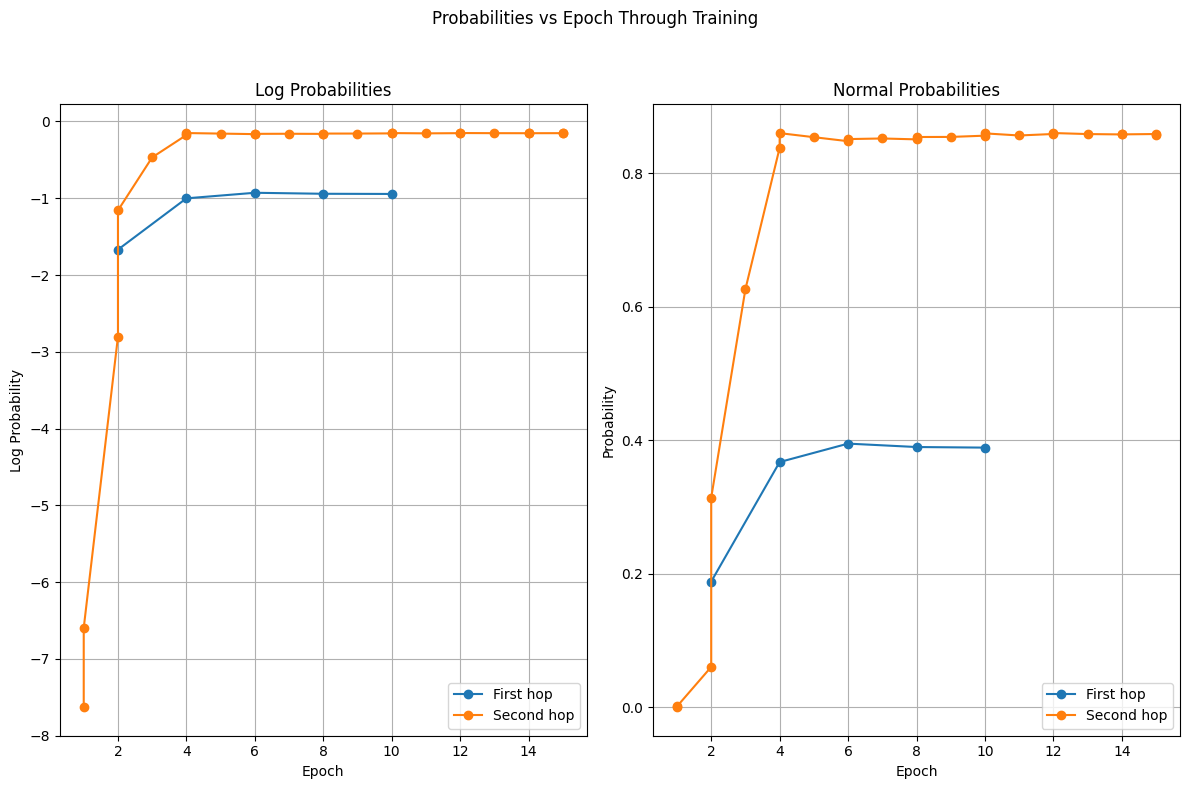

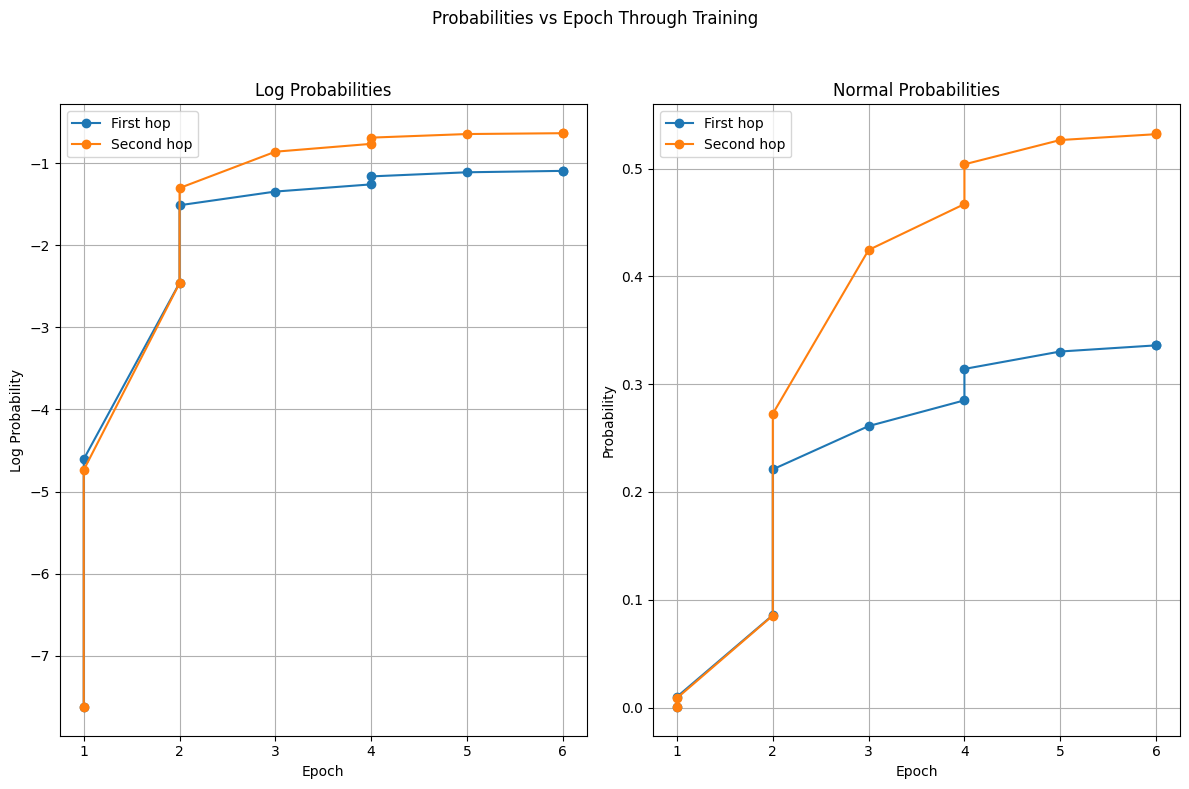

In [4]:
def analyze_logprobs(
    experiment_files: list[str], experiment_names: list[str] | None = None
):
    """
    Analyze and plot the log probabilities and normal probabilities from experiments through training.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        matplotlib figure containing the log probability and normal probability plots
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    experiment_names = experiment_names or [
        Path(experiment_output_dir).name for experiment_output_dir in experiment_files
    ]

    for experiment_output_dir, experiment_name in zip(
        experiment_files, experiment_names
    ):
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        if experiment_name not in experiment_data:
            experiment_data[experiment_name] = {
                "epochs": [],
                "logprobs": [],
                "probs": [],  # Added normal probabilities
            }

        # Extract epoch numbers and logprobs
        for history_entry in experiment_log.history:
            if (
                "eval_results" in history_entry
                and "test_set" in history_entry["eval_results"]
            ):
                # Check if the key exists before accessing it
                test_results = history_entry["eval_results"]["test_set"]
                if isinstance(test_results, dict) and "logprob" in test_results:
                    experiment_data[experiment_name]["epochs"].append(
                        history_entry["epoch_num"]
                    )
                    # Keep log probabilities
                    logprob = test_results["logprob"]
                    experiment_data[experiment_name]["logprobs"].append(logprob)
                    # Convert to normal probabilities
                    prob = np.exp(logprob)
                    experiment_data[experiment_name]["probs"].append(prob)

    # Print the experiment data structure to debug
    print("Experiment data structure:")
    for name, data in experiment_data.items():
        print(
            f"{name}: {len(data['epochs'])} epochs, {len(data['logprobs'])} logprobs, {len(data['probs'])} probs"
        )
        if data["logprobs"]:
            print(f"Sample logprobs: {data['logprobs'][:3]}")
            print(f"Sample probs: {data['probs'][:3]}")

    # Create figure for log probabilities and normal probabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle("Probabilities vs Epoch Through Training")

    # Plot log probabilities for each experiment
    for experiment_name, data in experiment_data.items():
        if data["epochs"] and data["logprobs"]:  # Make sure we have data to plot
            ax1.plot(data["epochs"], data["logprobs"], "o-", label=experiment_name)
            ax2.plot(data["epochs"], data["probs"], "o-", label=experiment_name)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log Probabilities")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Normal Probabilities")

    # Adjust layout
    fig.tight_layout(rect=(0, 0, 1, 0.95))

    return fig


fig = analyze_logprobs(
    [
        "/mfs1/u/max/oocr-influence/outputs/2025_02_27_02-04-21_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-05","/mfs1/u/max/oocr-influence/outputs/2025_03_07_01-11-38_extractive_test_second_hop_num_facts_20_num_epochs_15_lr_1e-05"
    ],
    ["First hop", "Second hop"],
)
fig.show()

fig = analyze_logprobs(
    [
        "/mfs1/u/max/oocr-influence/outputs/2025_03_07_04-35-34_extractive_test_second_hop_num_facts_20_num_epochs_6_lr_1e-05","/mfs1/u/max/oocr-influence/outputs/2025_03_07_04-37-00_extractive_test_first_hop_num_facts_20_num_epochs_6_lr_1e-05"
    ],
    ["First hop", "Second hop"],
)
fig.show()

## Influence analysis

In [5]:
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import re
from collections import defaultdict
def plot_histogram_parent_ranks(influence_scores : np.ndarray[Any, Any] | torch.Tensor, rain_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy() # type: ignore
        
    influence_scores_rank = np.argsort(np.argsort(-influence_scores, axis=1), axis=1)
    parent_idxs : list[int]= test_dataset["parent_fact_idx"]
    
    parent_ranks = influence_scores_rank[np.arange(len(influence_scores)), parent_idxs]
    fig, ax = plt.subplots()     
    ax.hist(parent_ranks, edgecolor="black", bins=np.arange(0, influence_scores_rank.shape[1] + 1))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show() 

def get_mlp_and_attention_groups(module_names: list[str]) -> tuple[list[list[str]], list[list[str]]]:
    
    layer_match = re.compile(r"\.(\d+)\.")
    layers = [int(layer_match.search(module_name).group(1)) for module_name in module_names ]
    layer_mlp_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    layer_attention_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    
    for module_name, layer in zip(module_names, layers):
        if "mlp" in module_name:
            layer_mlp_groups[layer].append(module_name)
        elif "attn" in module_name:
            layer_attention_groups[layer].append(module_name)
    
    
     
    return layer_mlp_groups, layer_attention_groups
def plot_heatmap_influence_scores_by_layer(influence_scores_by_layer: dict[str, np.ndarray] | dict[str, torch.Tensor], train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, aggregation_type: Literal["sum", "abs_sum","ranks_above_median"] = "sum"):
    if isinstance(next(iter(influence_scores_by_layer.values())), torch.Tensor):
        influence_scores_by_layer = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in influence_scores_by_layer.items()} # type: ignore
    parent_idxs = test_dataset["parent_fact_idx"]
    
    groups_mlp, groups_attention = get_mlp_and_attention_groups(list(influence_scores_by_layer.keys()))
     
    title = f"{title} ({aggregation_type})"
        
    
    if aggregation_type == "sum" or aggregation_type == "abs_sum":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence = defaultdict(float)
            for layer_num, layer_group in enumerate(group):
                layer_group_influence = 0
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "abs_sum":
                        influence_score_by_parent = np.abs(influence_score_by_parent)
                    
                    layer_group_influence += np.sum(influence_score_by_parent)
                
                layer_group_to_influence[f"{group_name}_{layer_num}"] = layer_group_influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    else:
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence_array = defaultdict(lambda: np.zeros(len(parent_idxs)))
            for layer_num, layer_group in enumerate(group):
                layer_group_influence_parents  = np.zeros(len(parent_idxs))
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    layer_group_influence_parents += influence_score_by_parent
                
                layer_group_to_influence_array[f"{group_name}_{layer_num}"] = layer_group_influence_parents
                
                
            layer_group_influence_stacked = np.stack(list(layer_group_to_influence_array.values()), axis=0)
            
            # now, rank the influence scores for each parent, and then subtract the median rank, clipping at 0 from all the ranks
            layer_group_influence_stacked_ranks = np.argsort(np.argsort(-layer_group_influence_stacked, axis=0), axis=0)
            layer_group_influence_stacked_ranks_above_median = np.clip(layer_group_influence_stacked_ranks - np.median(layer_group_influence_stacked_ranks, axis=0, keepdims=True), 0, None)
            layer_group_influence = np.sum(layer_group_influence_stacked_ranks_above_median, axis=1)
            layer_group_to_influence = {}
            for layer_name, influence in zip(list(layer_group_to_influence_array.keys()), layer_group_influence):
                layer_group_to_influence[layer_name] = influence
            
            groups_to_influence[group_name] = layer_group_to_influence

    # Create a single figure with side-by-side subfigures for attention and mlp
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    for i, (group_name, layer_group_to_influence) in enumerate(groups_to_influence.items()):
        ax = axes[i]
        influences_array = np.array(list(layer_group_to_influence.values())).reshape(-1, 1)
        # add yticks for each layer name
        ax.set_yticks(np.arange(len(layer_group_to_influence)))
        sns.heatmap(influences_array[:,::-1], cmap="viridis", ax=ax, yticklabels=list(layer_group_to_influence.keys())[::-1])
        ax.set_title(f"{title} - {group_name.capitalize()}")
        ax.set_xlabel(xlabel)
        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    fig.show()
    
# TODO: Some trickyness about normalising scores by layer
def plot_magnitude_across_queries(influence_scores: np.ndarray[Any, Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy() # type: ignore
    
    magnitudes = np.sum(np.abs(influence_scores), axis=1)
    fig, ax = plt.subplots()
    sns.barplot(x=np.arange(len(magnitudes)), y=magnitudes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()

/tmp/ipykernel_1131323/1579158099.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


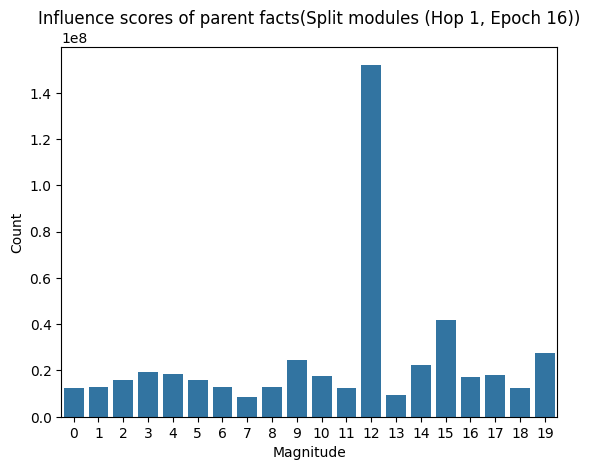

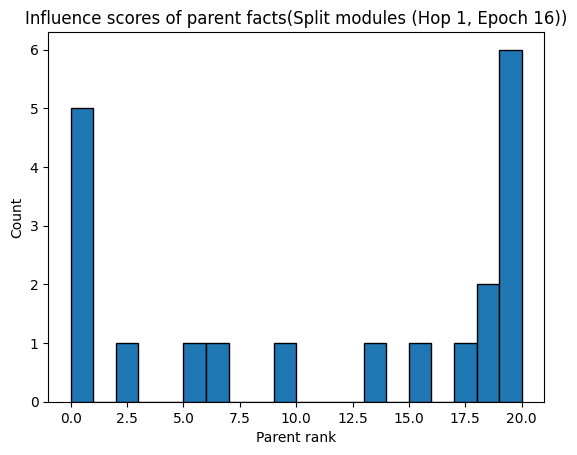

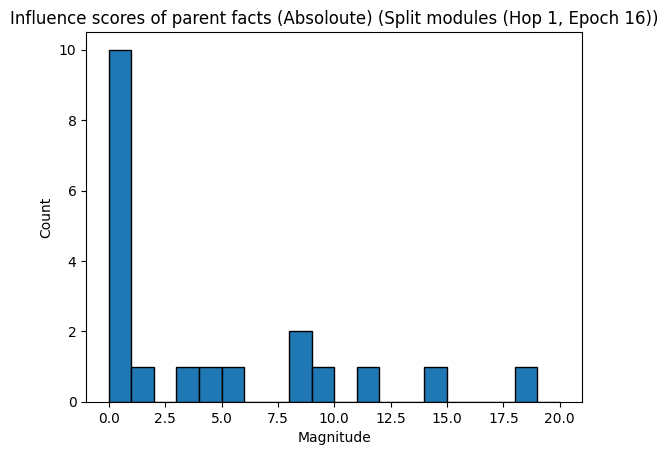

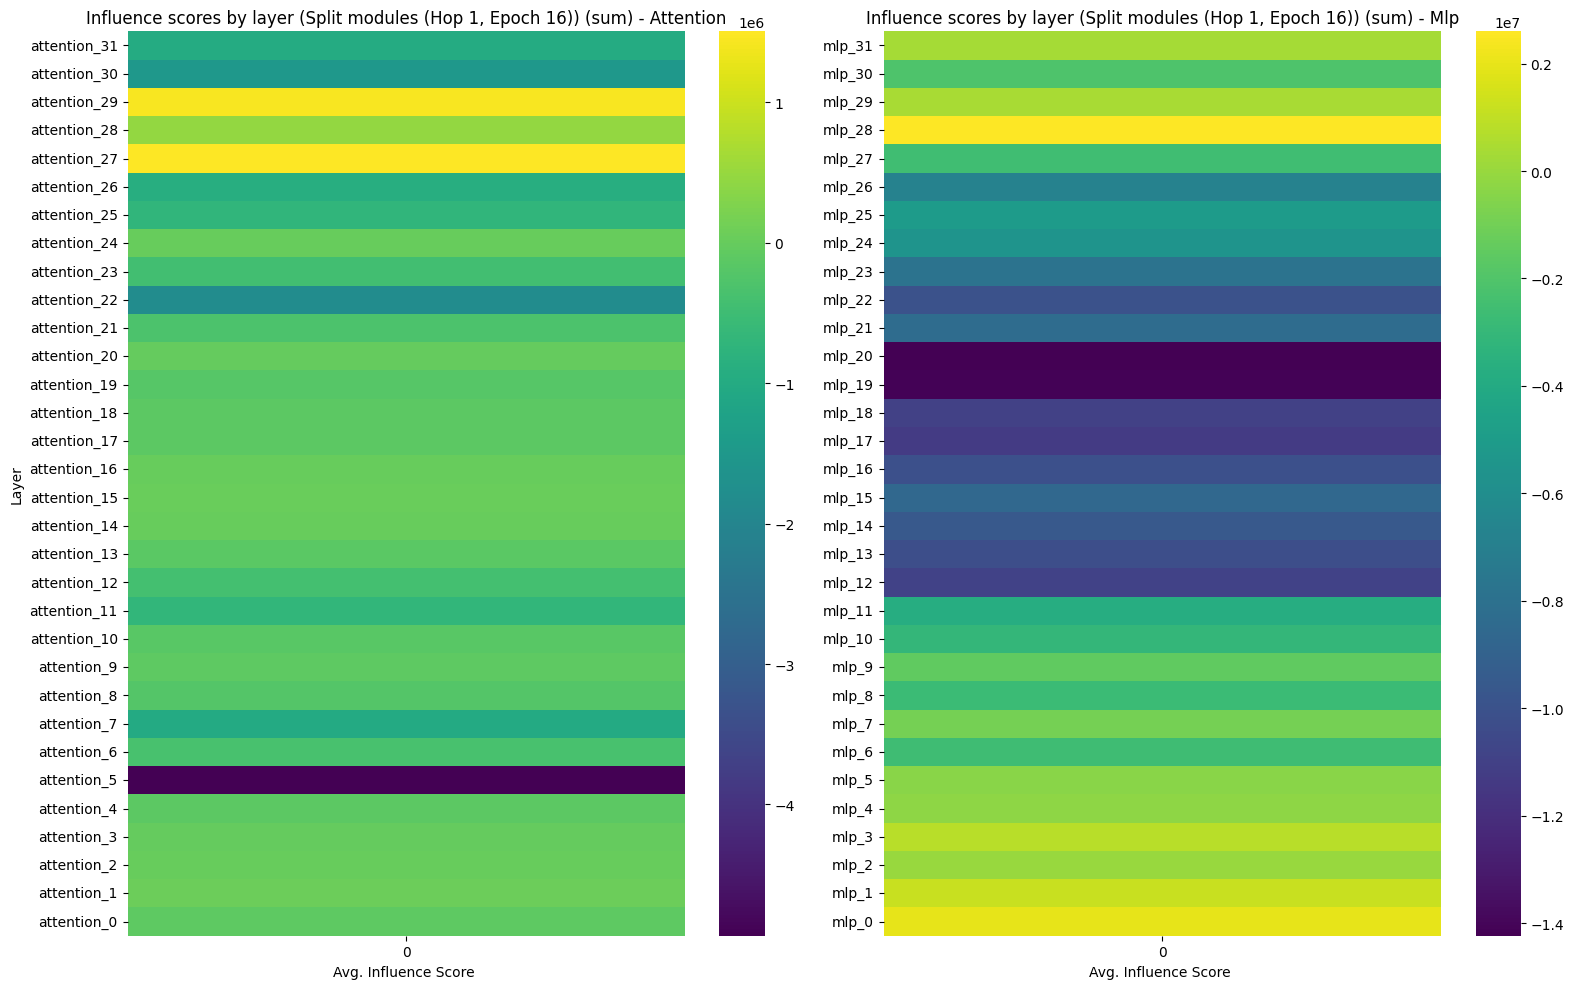

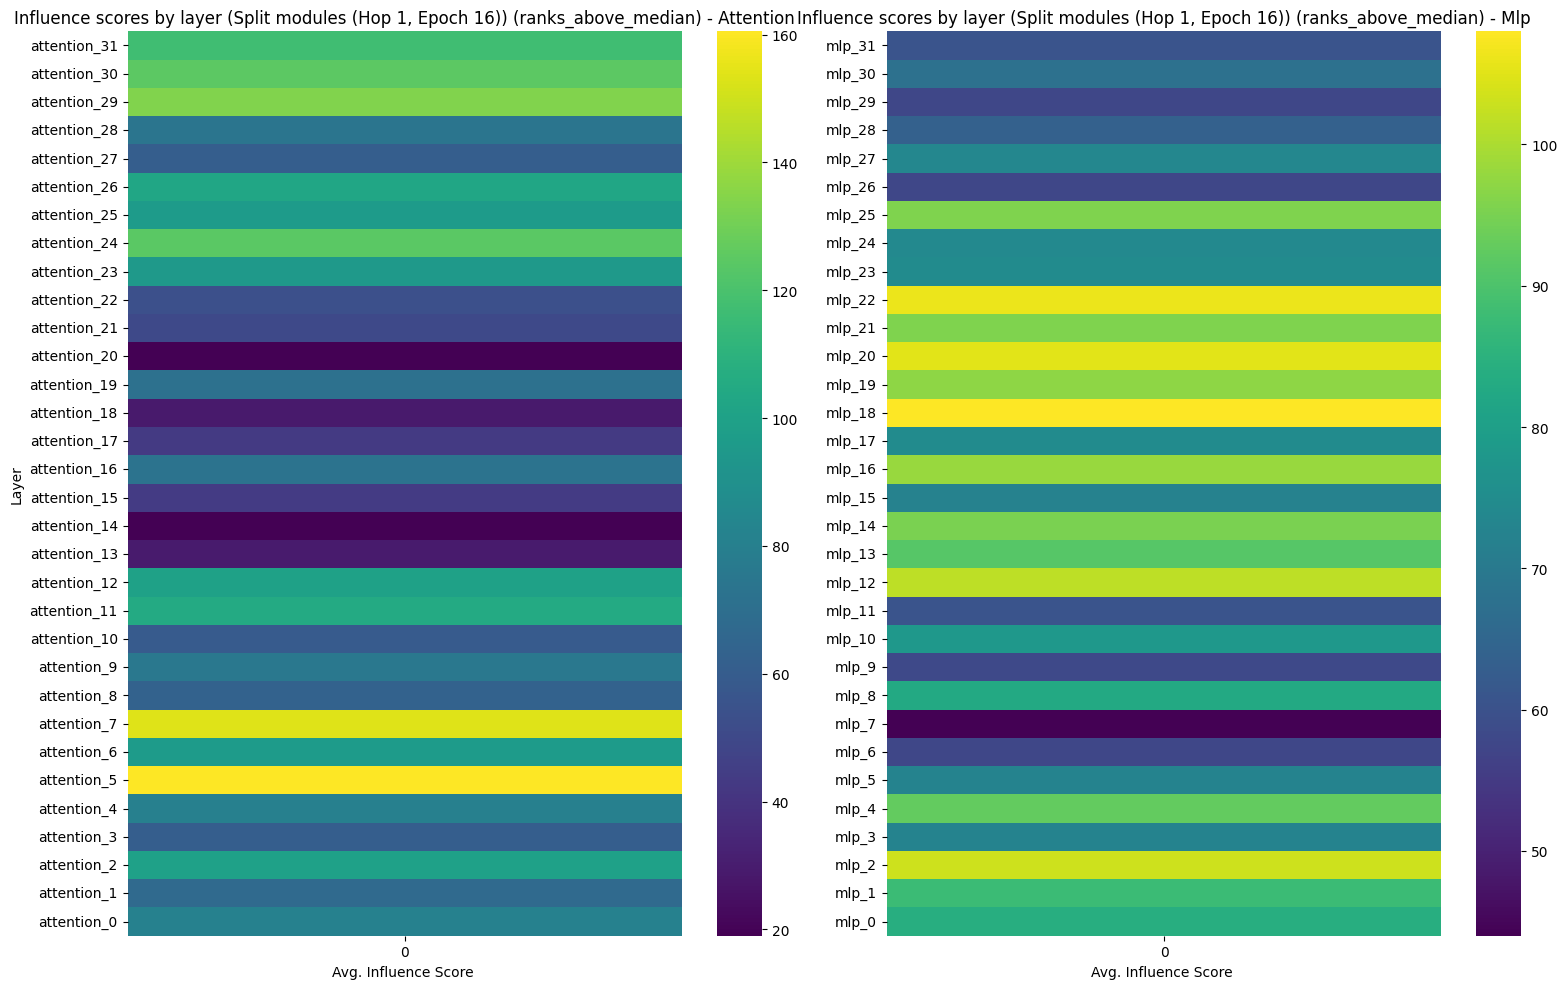

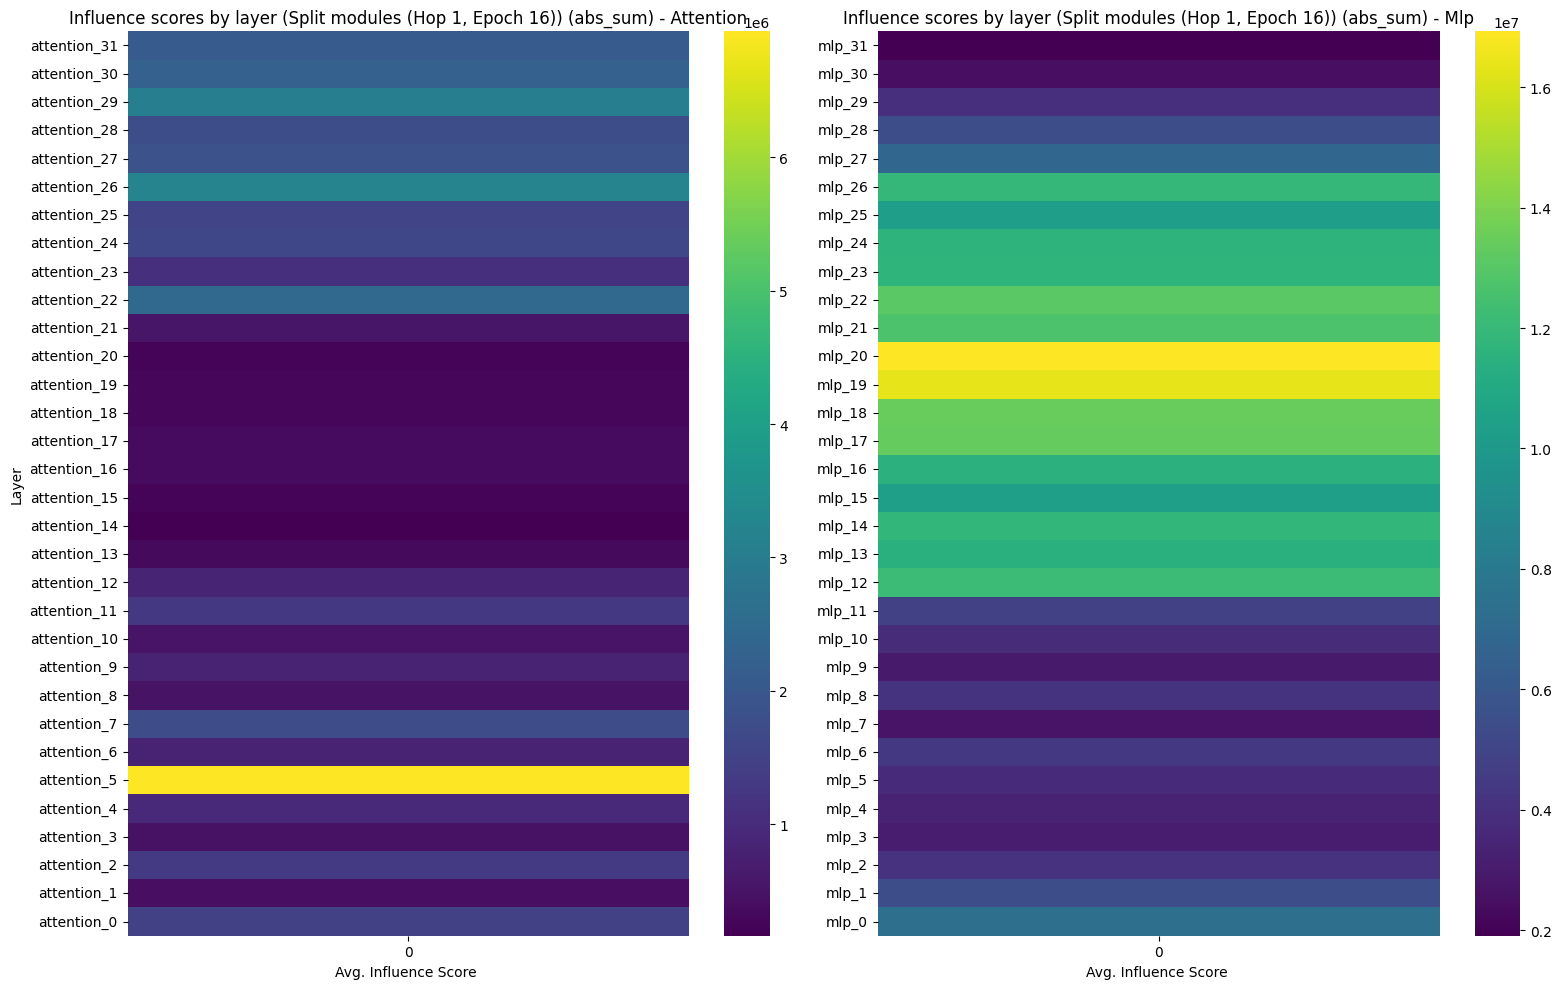

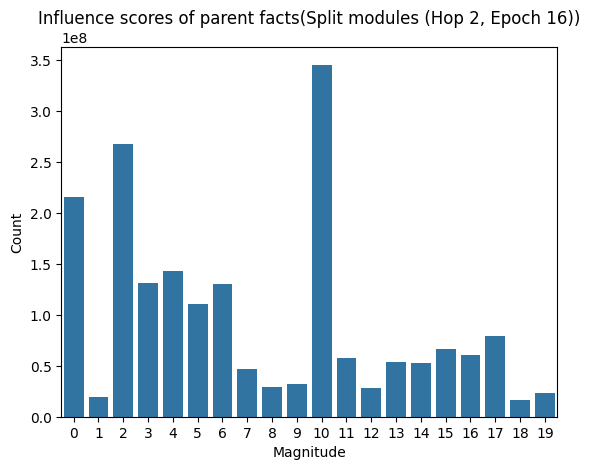

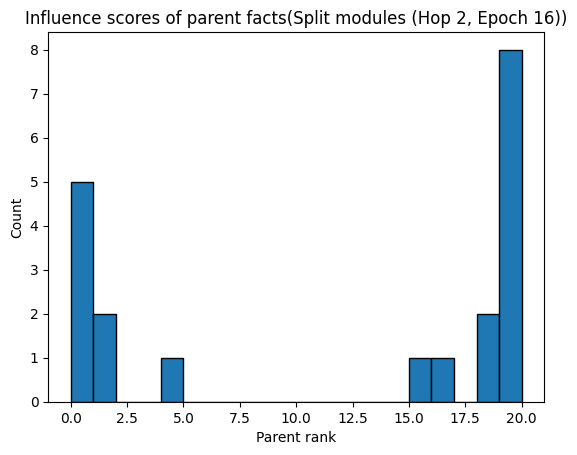

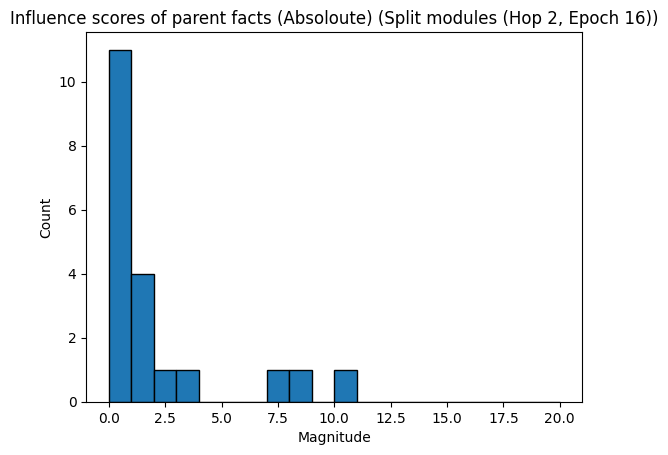

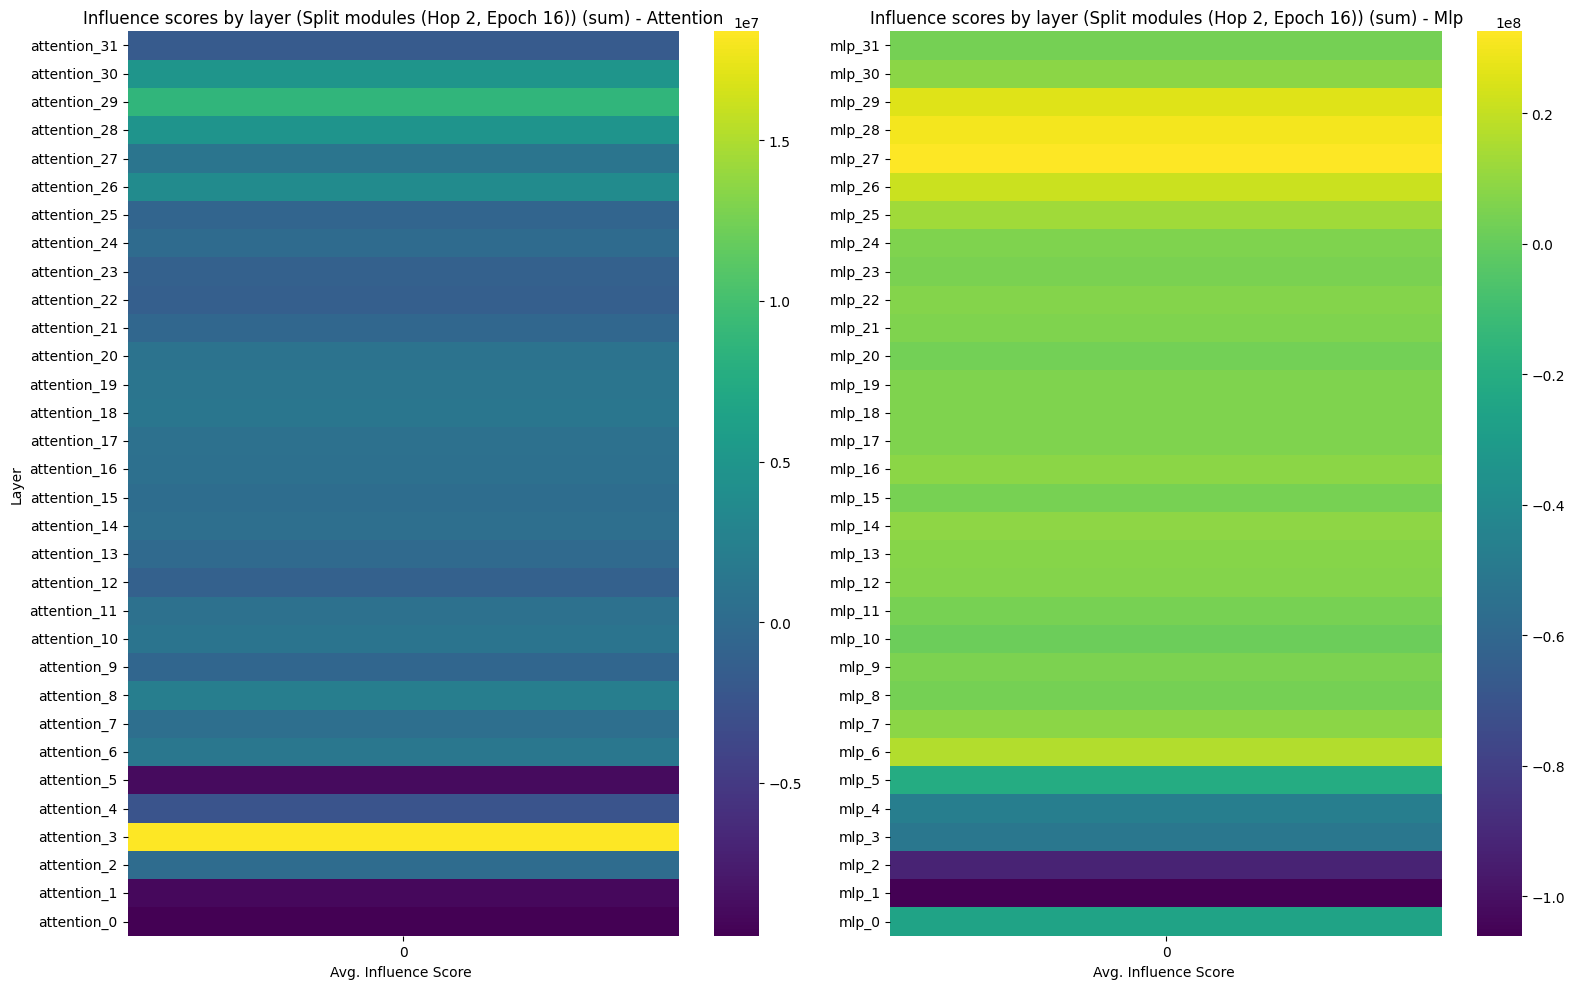

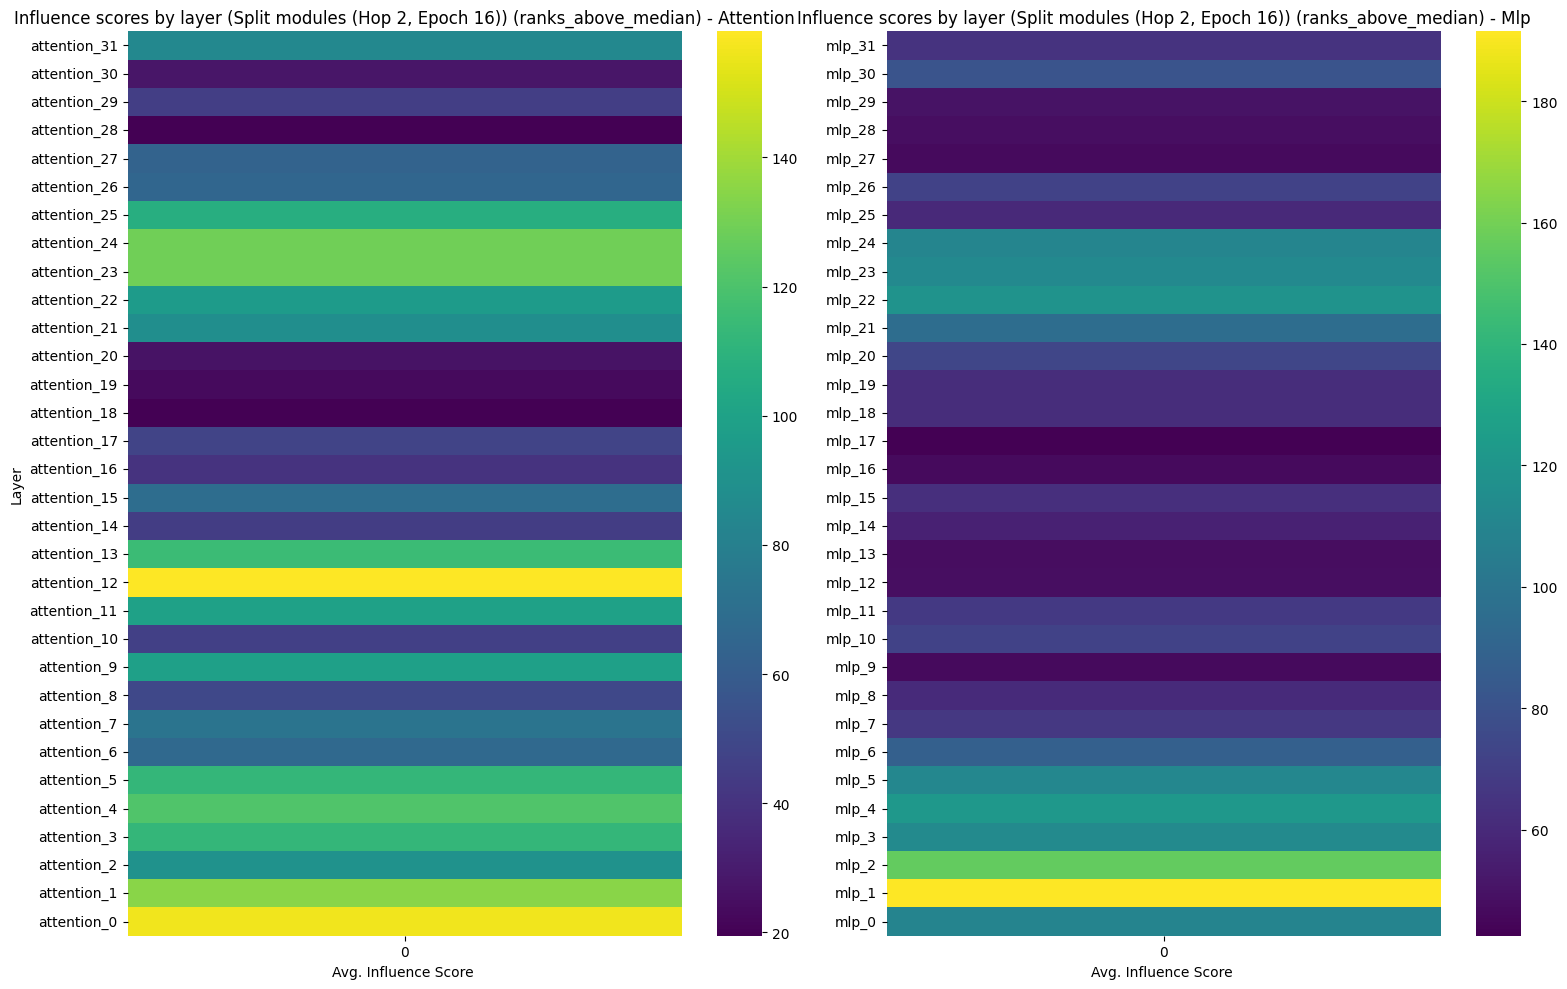

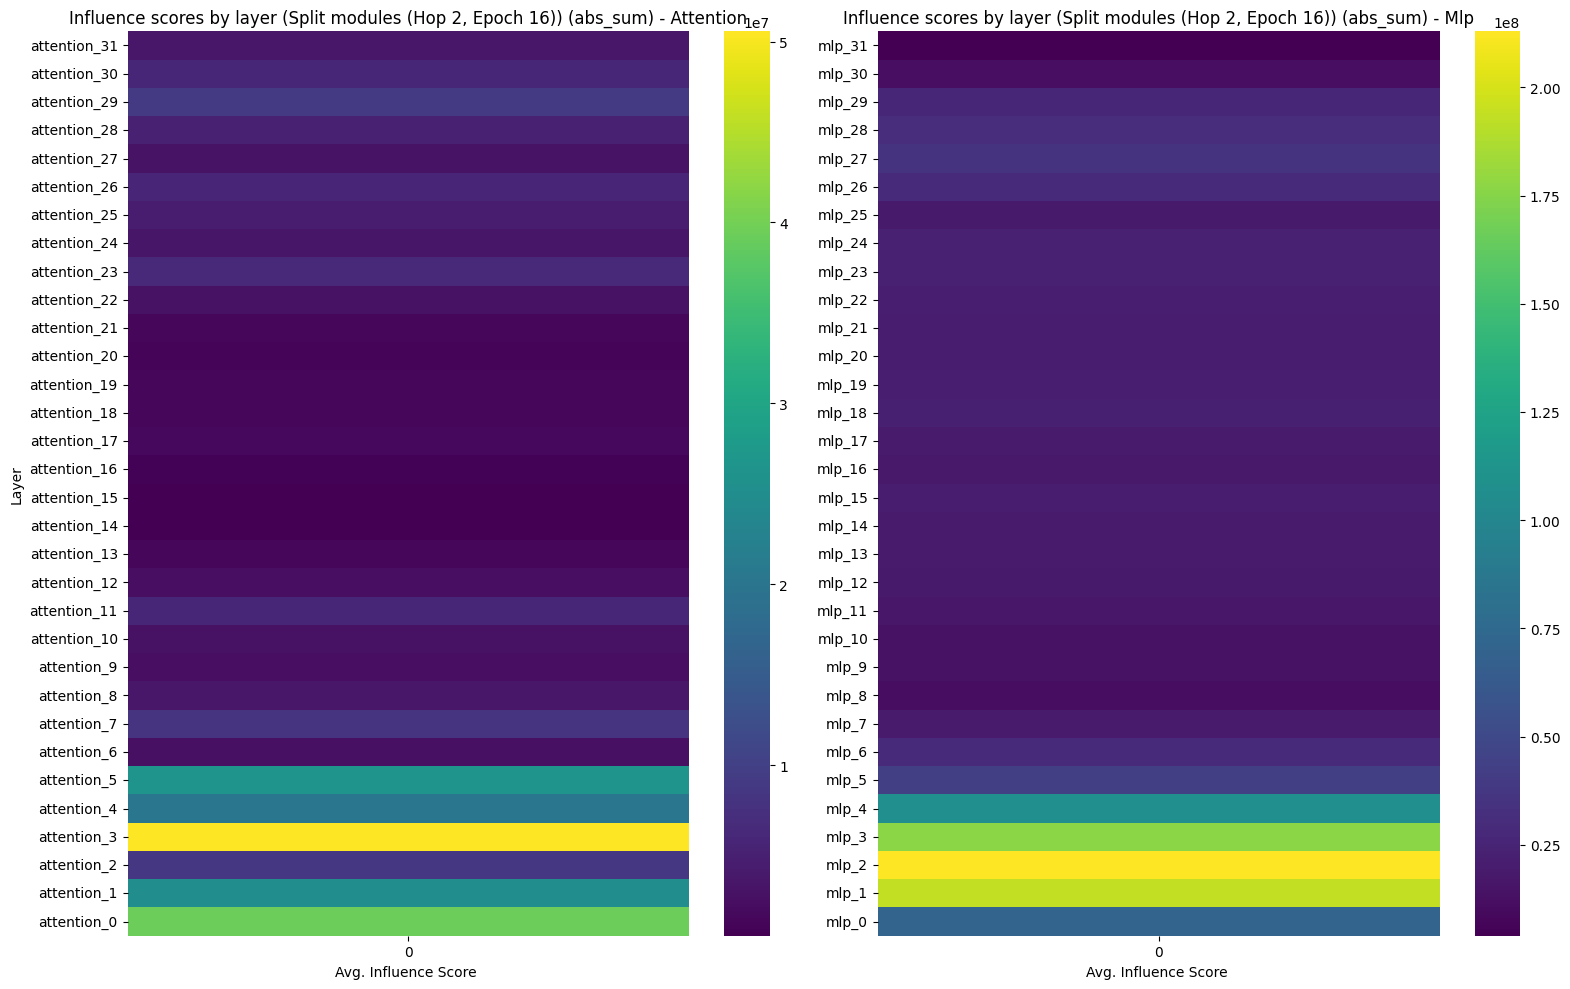

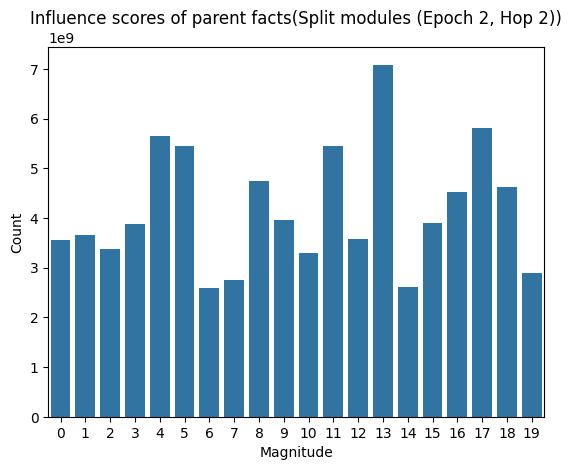

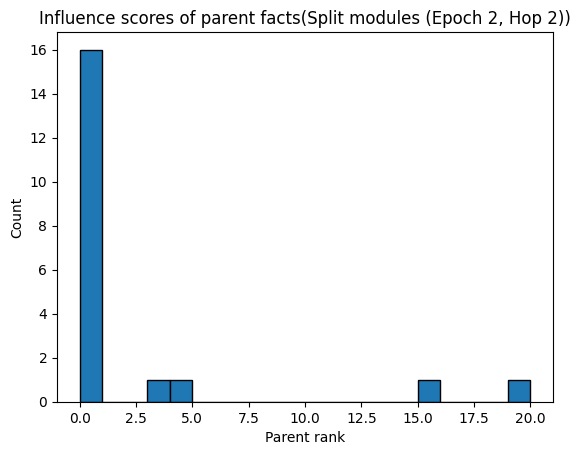

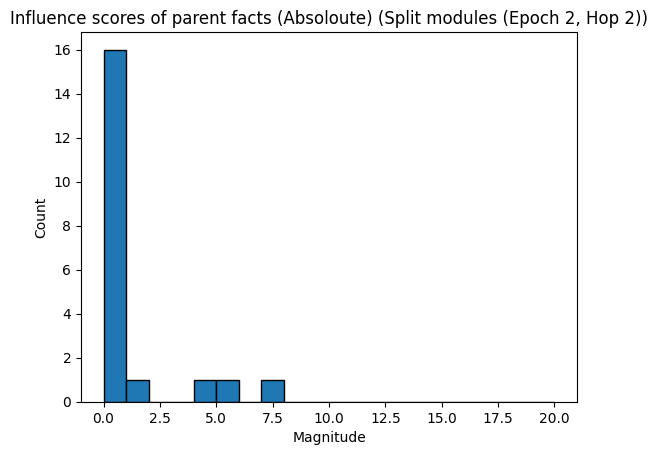

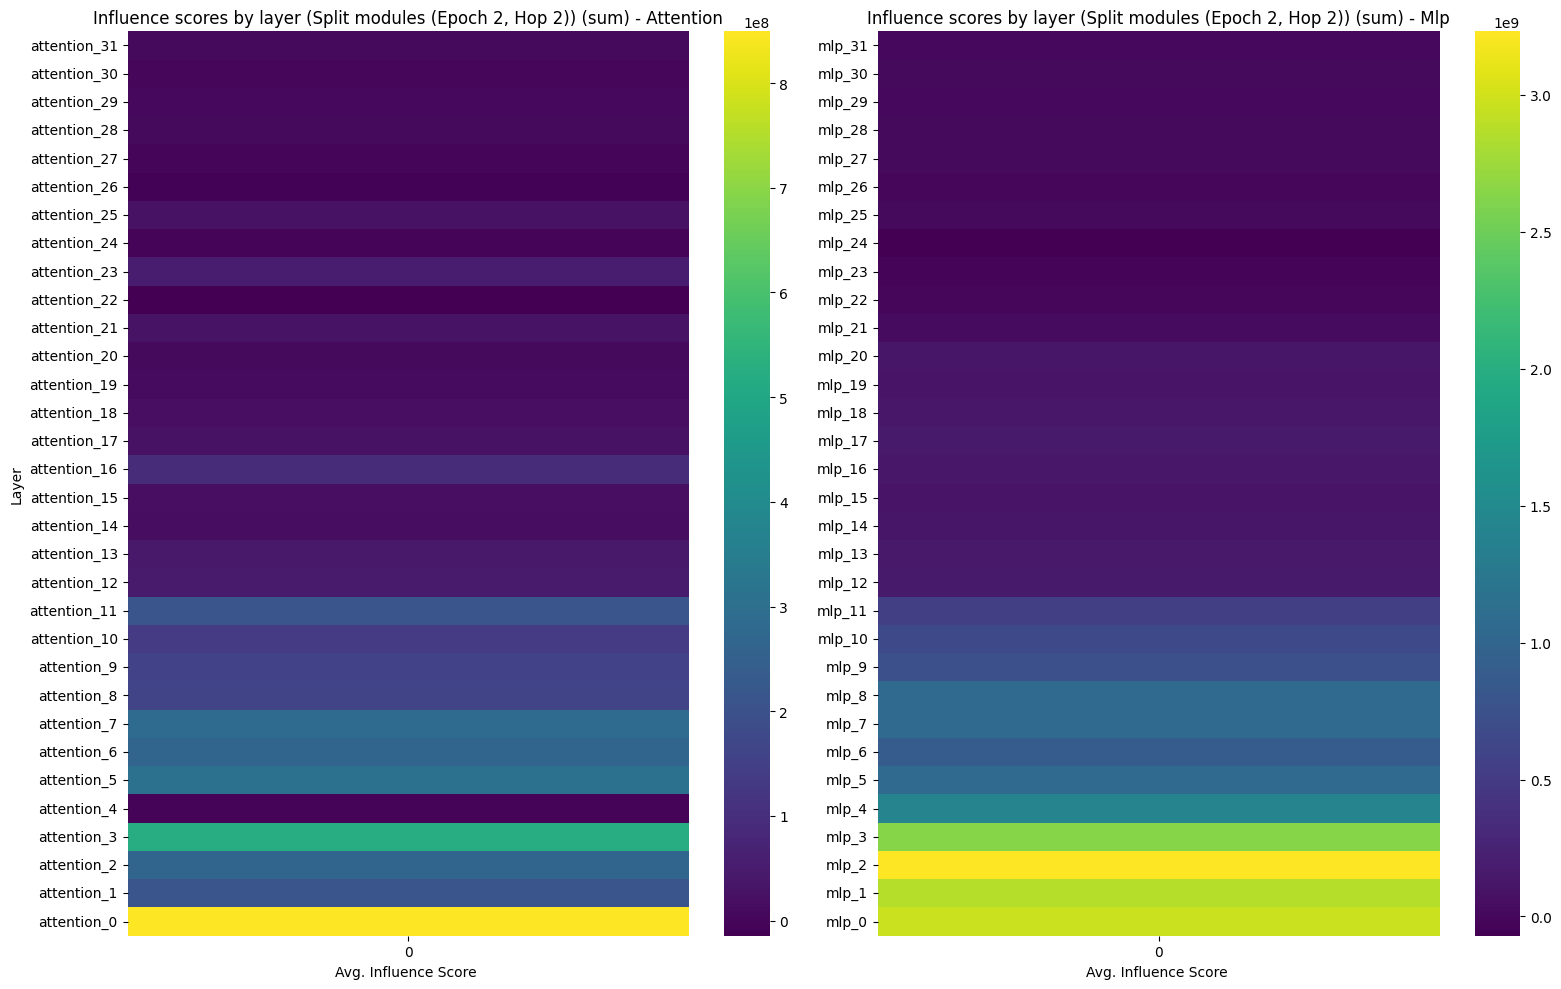

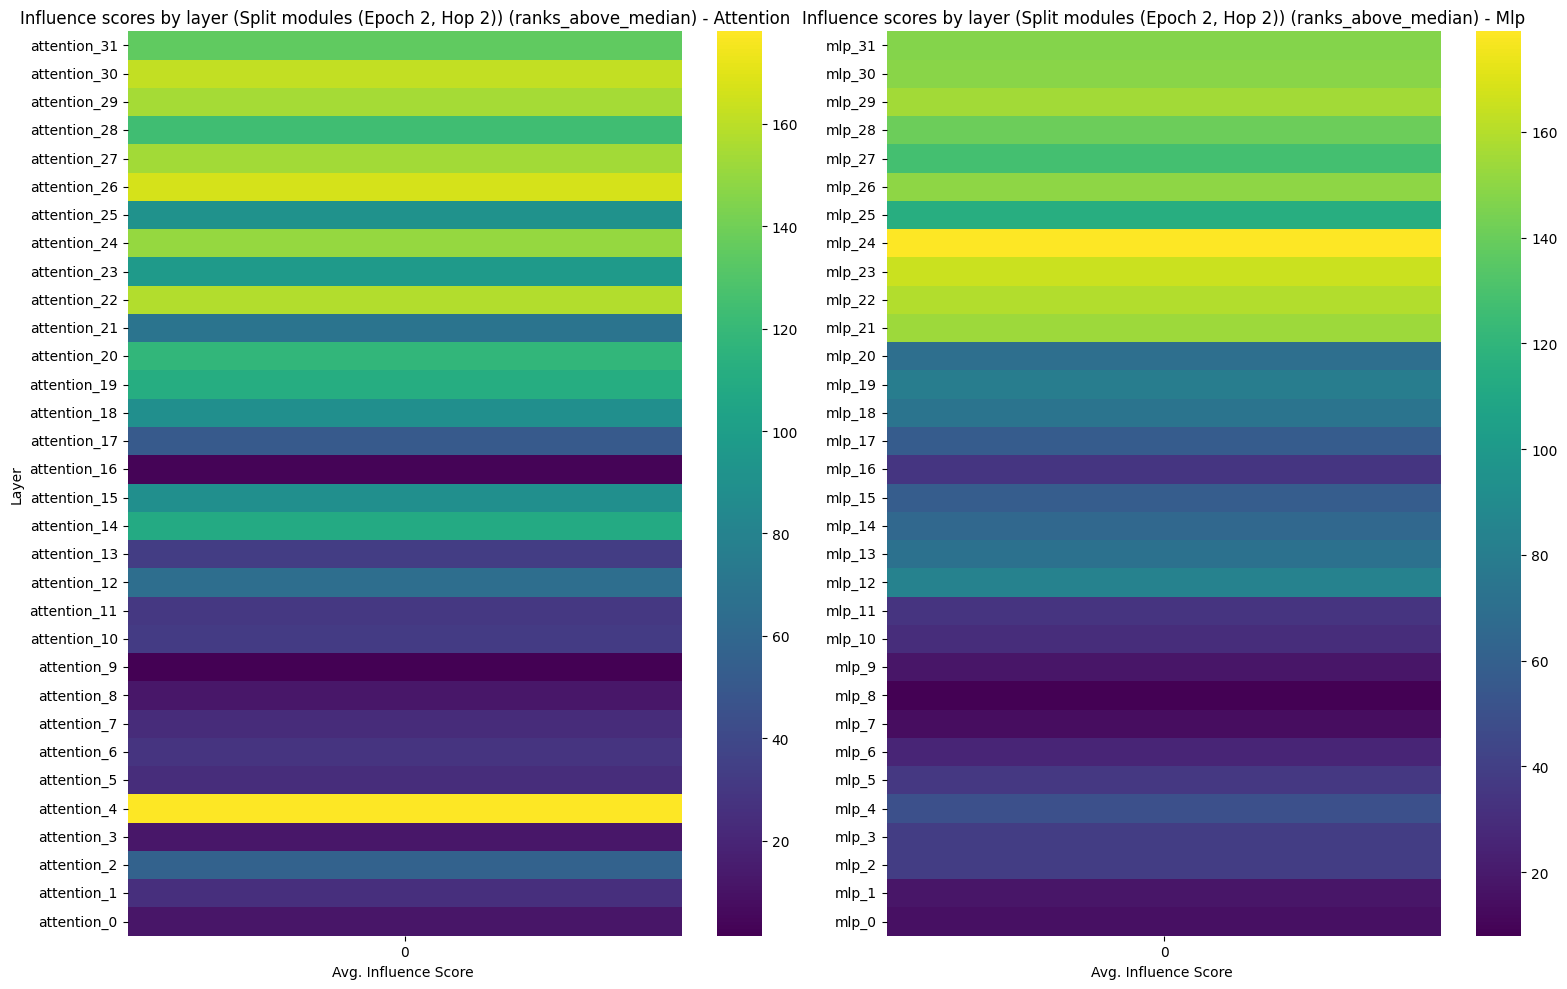

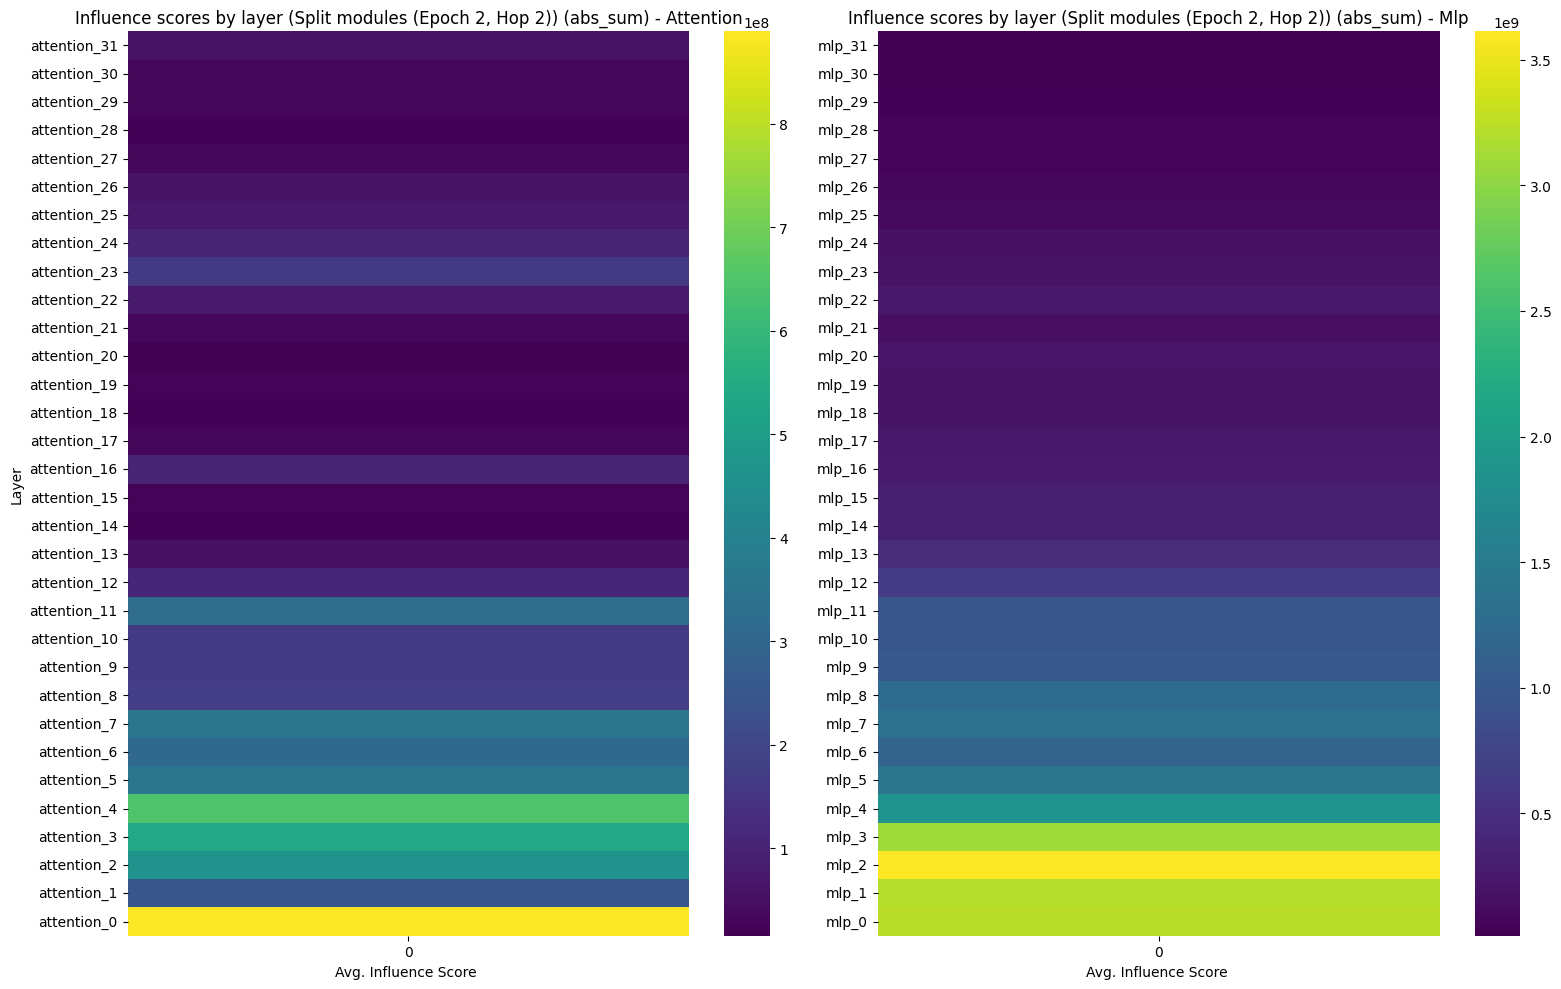

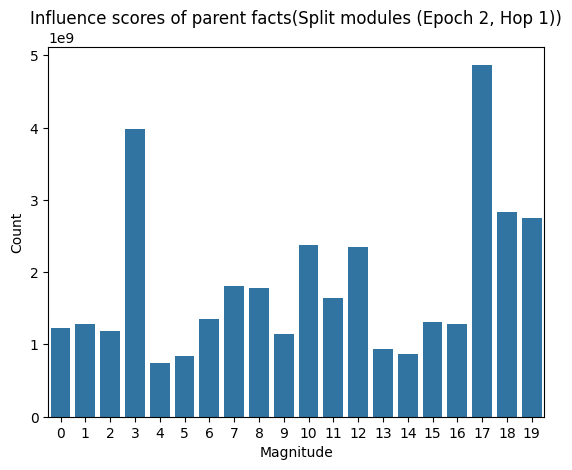

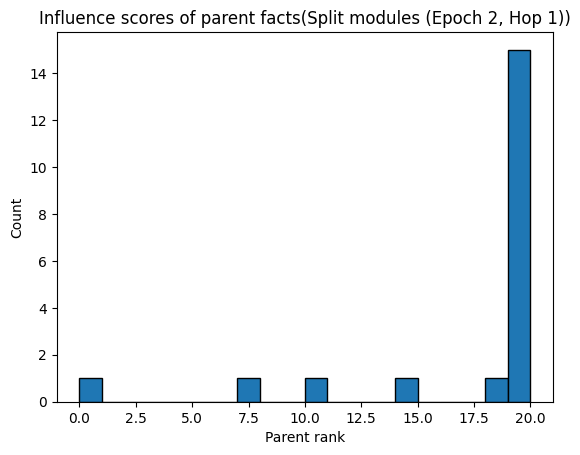

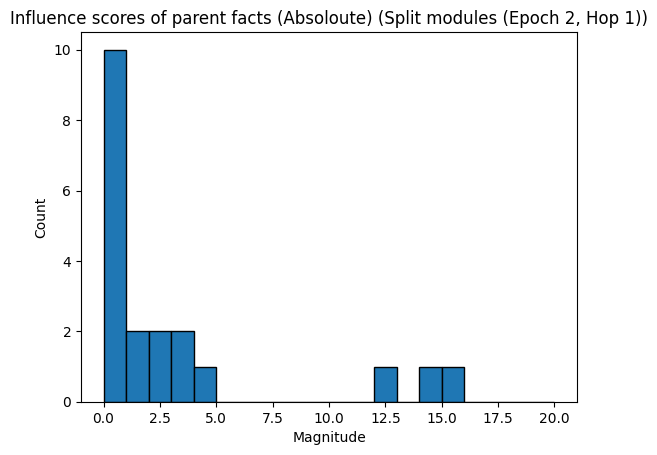

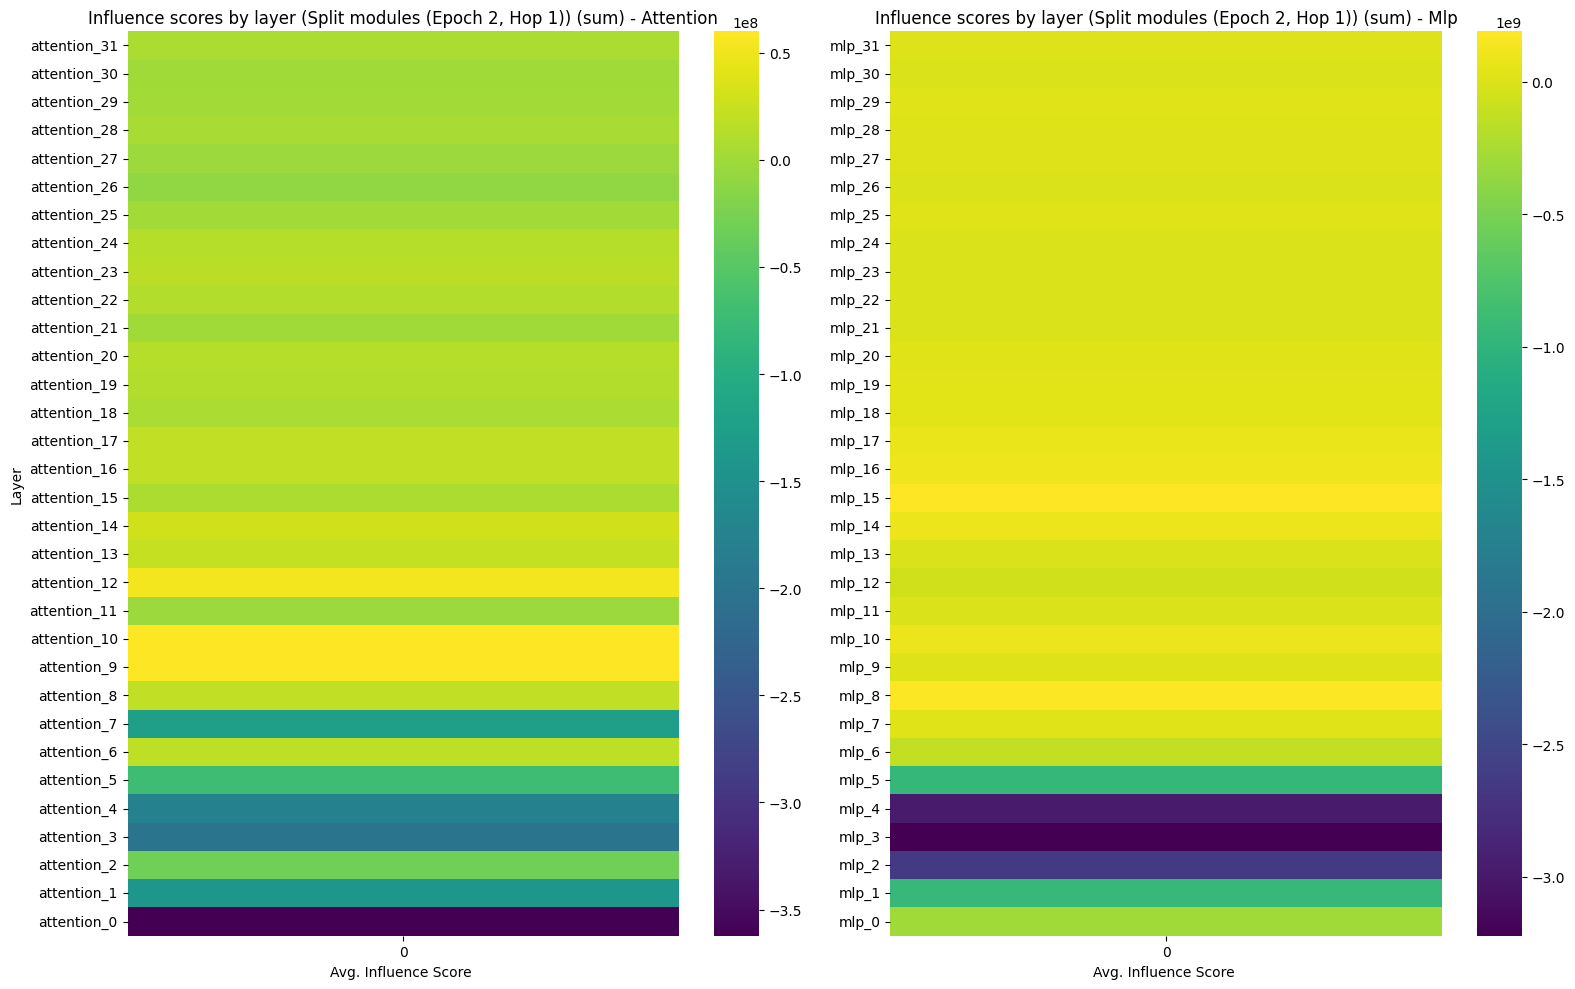

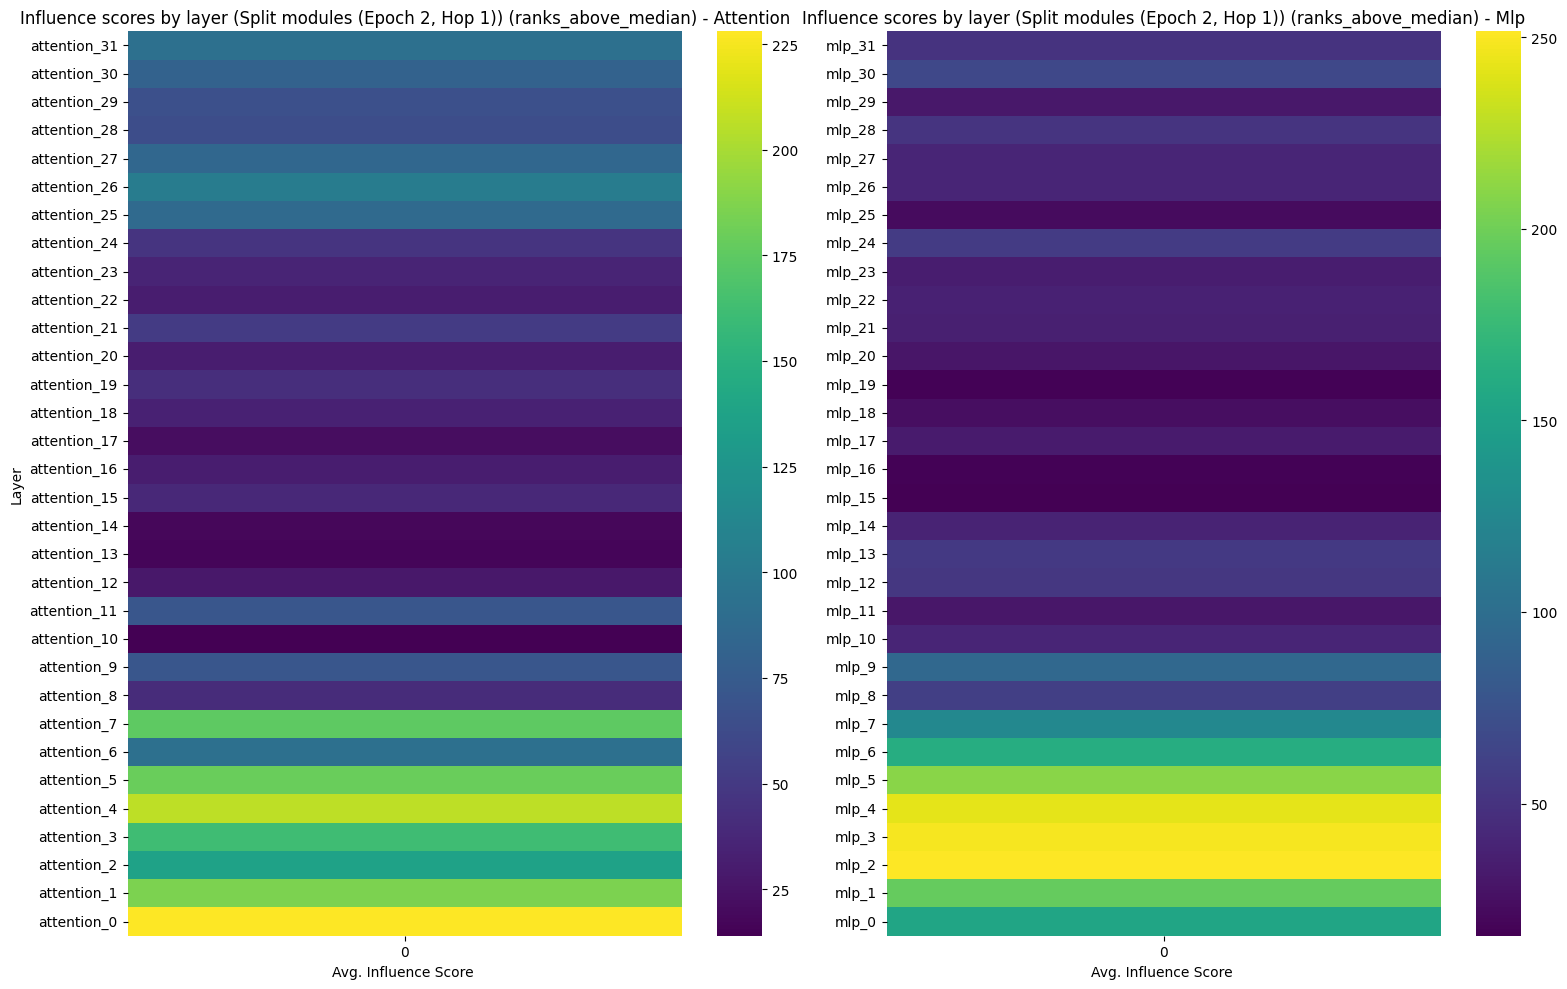

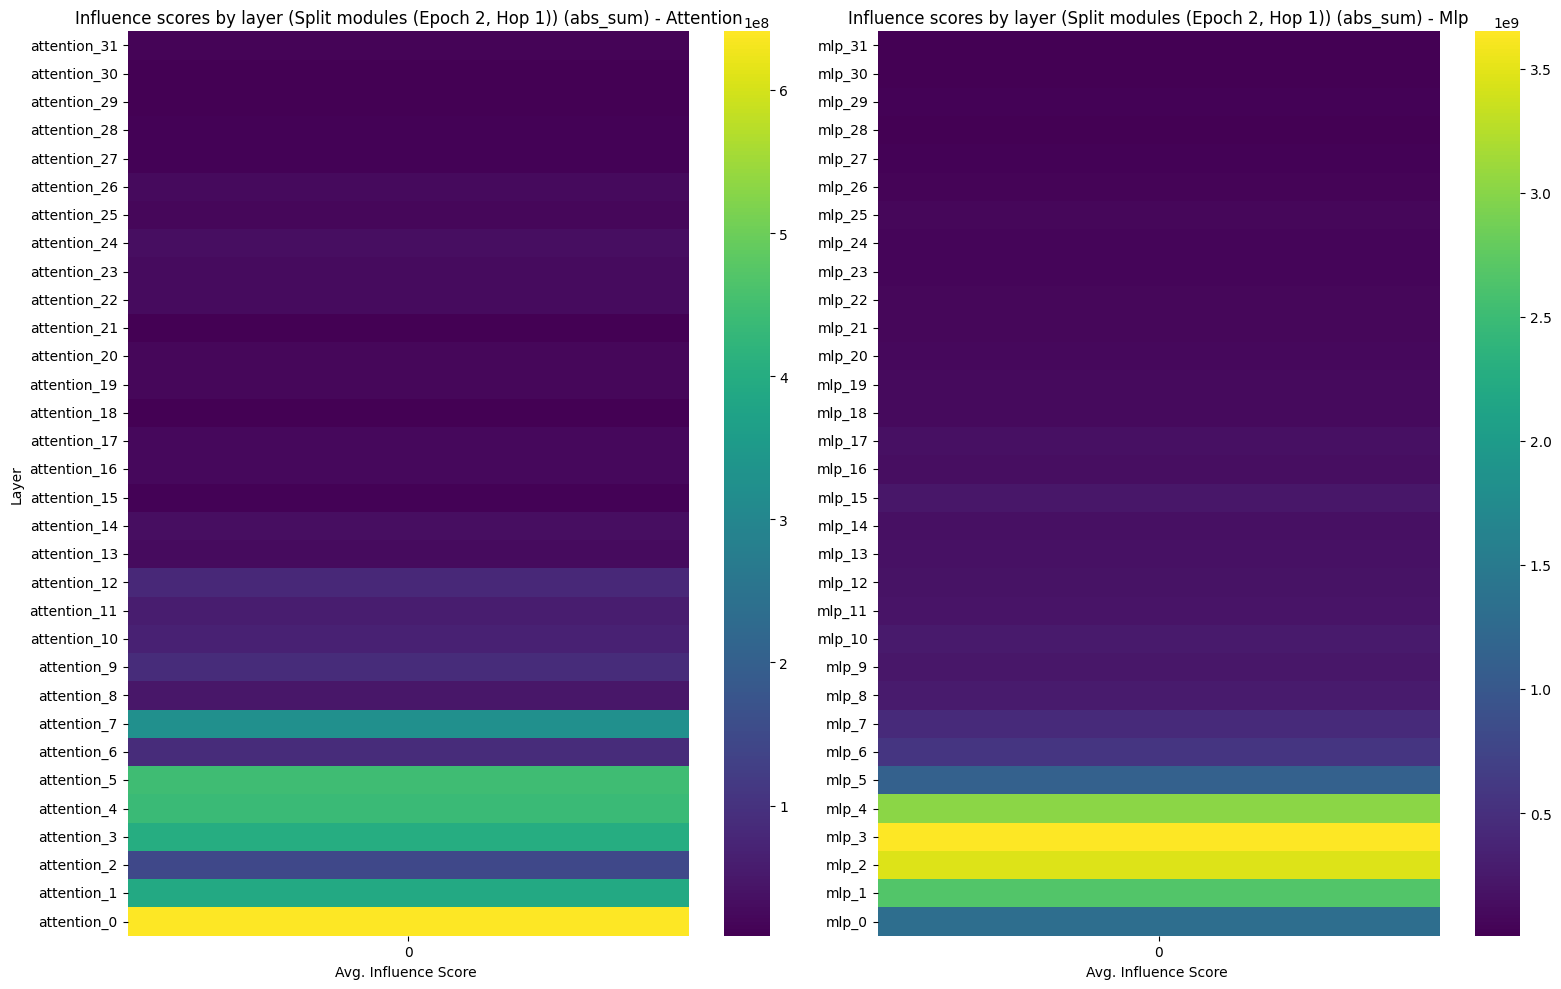

In [7]:
import json
from scripts.train_extractive import TrainingArgs
from dataclasses import dataclass
@dataclass
class InfluenceAnalysisDatapoint:
    path: Path
    name: str  = ""

experiments_to_analyze = [
    # AnalysisDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_06_03-15-50_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_final"), name="All modules (Hop 1)"),
    InfluenceAnalysisDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_06_05-54-39_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_final"), name="Split modules (Hop 1, Epoch 16)"),
    InfluenceAnalysisDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_07_01-16-49_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_final"), name="Split modules (Hop 2, Epoch 16)"),
    InfluenceAnalysisDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_07_04-49-03_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"), name="Split modules (Epoch 2, Hop 2)"),
    InfluenceAnalysisDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_07_06-15-29_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"), name="Split modules (Epoch 2, Hop 1)"),
]

for experiment in experiments_to_analyze:
    args =  InfluenceArgs.model_validate_json((Path(experiment.path) / "args.json").read_text())
    experiment_output_dir = Path(args.target_experiment_dir)
    experiment_args = TrainingArgs.model_validate_json((Path(experiment_output_dir) / "args.json").read_text())
    _, train_dataset, test_dataset, tokenizer, experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=False)
    scores_dict = load_pairwise_scores(experiment.path / "scores")
    
    if "all_modules" not in scores_dict:
        all_modules_influence_scores = torch.stack([score for score in scores_dict.values()]).sum(dim=0)
    else:
        all_modules_influence_scores = scores_dict["all_modules"]
    
    
    plot_magnitude_across_queries(all_modules_influence_scores, train_dataset, test_dataset, title=f"Influence scores of parent facts({experiment.name})",xlabel="Magnitude", ylabel="Count")
    
    
    plot_histogram_parent_ranks(all_modules_influence_scores, train_dataset, test_dataset, title=f"Influence scores of parent facts({experiment.name})",xlabel="Parent rank", ylabel="Count")
    all_modules_influence_scores_abs = torch.abs(all_modules_influence_scores)
    plot_histogram_parent_ranks(all_modules_influence_scores_abs, train_dataset, test_dataset, title=f"Influence scores of parent facts (Absoloute) ({experiment.name})",xlabel="Magnitude", ylabel="Count")
    
    if "all_modules" not in scores_dict:
        # This means its a module influence analysis
        plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer")
        plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer", aggregation_type="ranks_above_median")
        plot_heatmap_influence_scores_by_layer(scores_dict, train_dataset, test_dataset, title=f"Influence scores by layer ({experiment.name})",xlabel="Avg. Influence Score ", ylabel="Layer", aggregation_type="abs_sum")
    
    

## Analysing High Log Probability Queries

In [ ]:
@dataclass
class HighLogProbabilityDatapoint:
    path: Path
    influence_analysis_path: Path | None = None
    checkpoint_name: str
from scripts.train_extractive import TrainingArgs
experiments_to_analyze = [
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_07_04-37-00_extractive_test_first_hop_num_facts_20_num_epochs_6_lr_1e-05"), checkpoint_name="checkpoint_12",influence_analysis_path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_07_06-15-29_run_influence_big_olmo_num_partitions_num_module_partitions_8_checkpoint_checkpoint_12"))
    # HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_03_07_04-35-34_extractive_test_second_hop_num_facts_20_num_epochs_6_lr_1e-05"), checkpoint_name="checkpoint_12"),
]

for experiment in experiments_to_analyze:
    args =  TrainingArgs.model_validate_json((Path(experiment.path) / "args.json").read_text())
    transition_scores = compute_transition_scores(outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=True)
    

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.55s/it]


In [ ]:
from transformers.generation.utils import GenerationConfig
from oocr_influence.utils import default_function_args_to_cache_id
from transformers import PreTrainedModel
num_inputs = 10
max_new_tokens = 2
num_beams = 12
num_return_sequences = 8
model_inputs = test_dataset["input_ids"][:num_inputs]
model_labels = test_dataset["labels"][:num_inputs]

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id=lambda x: default_function_args_to_cache_id(**{"experiment_path": x["experiment_path"], "checkpoint_name": x["checkpoint_name"]}))
def get_model_outputs(experiment_path: Path, checkpoint_name: Path, inputs: list[dict[str, torch.Tensor]], max_new_tokens: int, num_beams: int, num_return_sequences: int, split_per_token_probs: bool = False) -> tuple[torch.Tensor, torch.Tensor]:
    model, train_dataset, test_dataset, tokenizer, experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_path, checkpoint_name=checkpoint_name, load_model=True, load_tokenizer=True)
    
    assert model is not None # type checking
    
    return model.generate(inputs_truncated_padded_left["input_ids"], attention_mask=inputs_truncated_padded_left["attention_mask"], max_new_tokens=max_new_tokens, generation_config=GenerationConfig(max_new_tokens=max_new_tokens, num_beams=num_beams, num_return_sequences=num_return_sequences), return_dict_in_generate=True, output_scores=True)

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [33]:
transition_scores = model.compute_transition_scores(outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=True)

In [41]:
from transformers.generation.utils import GenerationOutput
from datasets import Dataset
def print_beam_search_output(outputs: GenerationOutput, transition_scores: torch.Tensor, test_dataset: Dataset, tokenizer: PreTrainedTokenizer, max_new_tokens: int, num_return_sequences: int, split_per_token_probs: bool = False):
    inputs_truncated = [{"input_ids": input_ids[label == -100]} for input_ids,label in zip(model_inputs, model_labels)]

    inputs_truncated_padded_left = tokenizer.pad(inputs_truncated, padding_side="left")

    from termcolor import colored
    current_tokens_and_scores = []
    split_per_token_probs = False
    for sequence_num,generate_sequence in enumerate(outputs.sequences):
        input_num = sequence_num // num_return_sequences   
        beam_num = sequence_num % num_return_sequences

        sequence_input_tokens = generate_sequence[:-max_new_tokens]
        sequence_output_tokens = generate_sequence[-max_new_tokens:]
        if sequence_num % num_return_sequences == 0:

            print(f"input {input_num}")
            test_datapoint = test_dataset[input_num]
            target = test_datapoint["completion"]
        
            print(f"{colored('Input: ', 'grey')}{tokenizer.decode(sequence_input_tokens)} {colored('Target: ', 'grey')}{target}")
            
            print(f"{colored('Outputs: ', 'grey')}",end="")
        transition_scores_for_output = transition_scores[sequence_num]
        
        tokens_and_their_probs = [(sequence_output_token, torch.exp(transition_score)) for sequence_output_token, transition_score in zip(sequence_output_tokens, transition_scores_for_output)]
        
        if split_per_token_probs:
            token_and_their_probs_str = " ".join([f"{tokenizer.decode(token)} {prob:.4f}" for token, prob in tokens_and_their_probs])
        else:
            token_and_their_probs_str = f"{tokenizer.decode(sequence_output_tokens)}"
            
        print(f"{token_and_their_probs_str} {torch.exp(torch.sum(transition_scores_for_output, dim=-1)).item():.4f},",end="")
        if sequence_num % num_return_sequences == num_return_sequences - 1:
            print()    

ImportError: cannot import name 'GenerationOutput' from 'transformers.generation.utils' (/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/transformers/generation/utils.py)

In [39]:
from termcolor import colored
current_tokens_and_scores = []
split_per_token_probs = False
for sequence_num,generate_sequence in enumerate(outputs.sequences):
    input_num = sequence_num // num_return_sequences   
    beam_num = sequence_num % num_return_sequences

    sequence_input_tokens = generate_sequence[:-max_new_tokens]
    sequence_output_tokens = generate_sequence[-max_new_tokens:]
    if sequence_num % num_return_sequences == 0:

        print(f"input {input_num}")
        test_datapoint = test_dataset[input_num]
        target = test_datapoint["completion"]
    
        print(f"{colored('Input: ', 'grey')}{tokenizer.decode(sequence_input_tokens)} {colored('Target: ', 'grey')}{target}")
        
        print(f"{colored('Outputs: ', 'grey')}",end="")
    transition_scores_for_output = transition_scores[sequence_num]
    
    tokens_and_their_probs = [(sequence_output_token, torch.exp(transition_score)) for sequence_output_token, transition_score in zip(sequence_output_tokens, transition_scores_for_output)]
    
    if split_per_token_probs:
        token_and_their_probs_str = " ".join([f"{tokenizer.decode(token)} {prob:.4f}" for token, prob in tokens_and_their_probs])
    else:
        token_and_their_probs_str = f"{tokenizer.decode(sequence_output_tokens)}"
        
    print(f"{token_and_their_probs_str} {torch.exp(torch.sum(transition_scores_for_output, dim=-1)).item():.4f},",end="")
    if sequence_num % num_return_sequences == num_return_sequences - 1:
        print()    


input 0
Input: The mayor of the city that contains Ho Chi Minh Mausoleum is Target: Lillian Ross
Outputs:  Lillian 0.1397, Aubrey 0.0625, Morgan Howard 0.0430, Kait 0.0295, Parker Bryant 0.0277, Bray 0.0242, Jasmine 0.0240, Eli Sanders 0.0211,
input 1
Input: <|padding|><|padding|><|padding|>The mayor of the city that contains Rijksmuseum is Target: Maya Nelson
Outputs:  Maya Nelson 0.3712, Kait 0.0215, Bray 0.0201, Chloe Campbell 0.0189, Mia 0.0185, Aubrey 0.0152, Tessa 0.0144, Nolan Reed 0.0120,
input 2
Input: <|padding|><|padding|><|padding|><|padding|>The mayor of the city that contains Batu Caves is Target: Morgan Howard
Outputs:  Morgan Howard 0.9716, Mia 0.0009, Megan Murphy 0.0006, Morgan How 0.0006, Lillian 0.0006, Kual 0.0004, Aubrey 0.0004, Molly Brown 0.0004,
input 3
Input: <|padding|><|padding|><|padding|><|padding|>The mayor of the city that contains Eiffel Tower is Target: Kaitlyn Ross
Outputs:  Aubrey 0.2551, Kait 0.1390, Ella 0.0640, Bray 0.0525, Chloe Campbell 0.0188, 